# Introduction

This notebook explores a model-free approach to detecting periods of clear skies.  It uses a moving window similar to the algorithm in PVLib.  This algorithm uses a two derived metrics from irradiance data.  

The first metric is the normalized line-length for a window of time.  It is calculated as follows:

$L_\text{norm} = \frac{\sum_{i=1}^{n-1} \sqrt{ (GHI_{i + 1} - GHI_{i})^2 + (t_{i + 1} - t_{i})^2}}
{\sqrt{ (GHI_n - GHI_1)^2 + (t_n - t_1)^2}}$

This metric serves as a measure of how much irradiance data deviates from a straight line between endpoints of the window.

The second metric is the local irradiance:

$I_\text{local} = \sum_{i=1}^n GHI_{i}$

These two metrics are combined into a composite metric referred to as "cloudiness" which is calculated via:

$\text{cloudiness} = \frac{L_\text{norm}}{I_\text{local}}$

The idea is that during times of clear skies, the GHI curve will be smooth, so $L_\text{norm}$ will be relatively low and $I_\text{local}$ will be relatively high, resulting in a low cloudiness factor.  When the sky is cloudy, the GHI curve will not be smooth (increased $L_\text{norm}$) and irradiance will be lower ($I_\text{local}$), which will result in a high cloudiness factor.

For each window, the normalized length, local irradiance, and cloudiness metric will be calculated.  If the window is below some threshold, the midpoint of the window is labelled as clear.

There are a few variations to this algorithm implemented, the democratic and mean methods.  For these variations, each window a point is in is considered when labelling the point clear or not.  This is explained by the following example, with a window size of 3 and we are looking at the value 4 (position 5).

[0 1 2 3 4 5 6 7 8]

This position would be included in 3 different windows,

[0 1 {2 3 4} 5 6 7 8], [0 1 2 {3 4 5} 6 7 8], [0 1 2 3 {4 5 6} 7 8].

In the democratic method, a certain percentage of windows must be passed in order for the original midpoint (position 5) to be considered clear.  In the mean method, the mean value of cloudiness across all windows is considered in determining clarity of the midpoint.

This approach was chosen because there were irradiance data sets where the PVLib (model-based) detection method struggled greatly.  It appeared that fitting the clear sky curve to the measured curve was a source of the inability to detect clear skies.  Additionally, using a model-free approach would open the possibility of using this algorithm on other PV measurments where models may not be available (power production, IV, etc).

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

%load_ext autoreload
%autoreload 2

# Load irradiance data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')

In [3]:
cols = ['Global_Wm2', 'Date-Time']

In [4]:
data = pd.read_csv(file, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])

In [5]:
data.index = data.index.tz_localize('Etc/GMT+7')

In [6]:
data = data.reindex(
    pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')
).fillna(0)

In [7]:
data = pd.Series(data['Global_Wm2'], index=data.index)

In [8]:
print(type(data))

<class 'pandas.core.series.Series'>


In [9]:
data[data < 50] = 0

# Set up PVLib system

In [10]:
site_azimuth = 180
site_elevation = 1658
site_tilt = 35
site_lat = 35.0549
site_lon = -106.5433

In [11]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=site_tilt, surface_azimuth=site_azimuth)
rtc_loc = pvlib.location.Location(site_lat, site_lon, altitude=site_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

# Test method

In [12]:
def metrics_plot(series, is_clear, result):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

    ax[0].set_title('Clear periods')
    _ = ax[0].plot(series.index, series)
    _ = ax[0].scatter(series.index[is_clear], series[is_clear], facecolor='none', edgecolor='green')
    
    ax[1].set_title('Metric')
    _ = ax[1].plot(series.index, series)
    p = ax[1].scatter(series.index, series, c=result['metric'], cmap=matplotlib.cm.jet, s=10, zorder=10, alpha=.8)
    fig.colorbar(p, ax=ax[1], label='cloudiness')

    fig.tight_layout()

In [13]:
def pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5))

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~pvlib_is_clear], sample[is_clear & ~pvlib_is_clear], 
               facecolor='none', edgecolor='green', label='model free')
    _ = ax.scatter(sample.index[pvlib_is_clear & ~is_clear], sample[pvlib_is_clear & ~is_clear], 
               facecolor='none', edgecolor='red', label='pvlib')
    _ = ax.scatter(sample.index[pvlib_is_clear & is_clear], sample[is_clear & pvlib_is_clear], 
               facecolor='none', edgecolor='yellow', label='both')
    _ = ax.legend()
    
    ax = axes[1]
    _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='model free')
    _ = ax.plot(pvlib_is_clear.index, np.cumsum(pvlib_is_clear.astype(int)), label='pvlib')
    _ = ax.legend()
    
    fig.tight_layout()

## Clear sky verification

In [14]:
sample = data[(data.index >= '2016-07-01') & (data.index < '2016-07-08')]

In [15]:
clear_skies = rtc.get_clearsky(sample.index)
clear_skies = clear_skies['ghi']

### Standard method

In [16]:
is_clear, cs_result = clearsky_detect_model_free.model_free_detect(clear_skies, metric_tol=.05, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:55: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


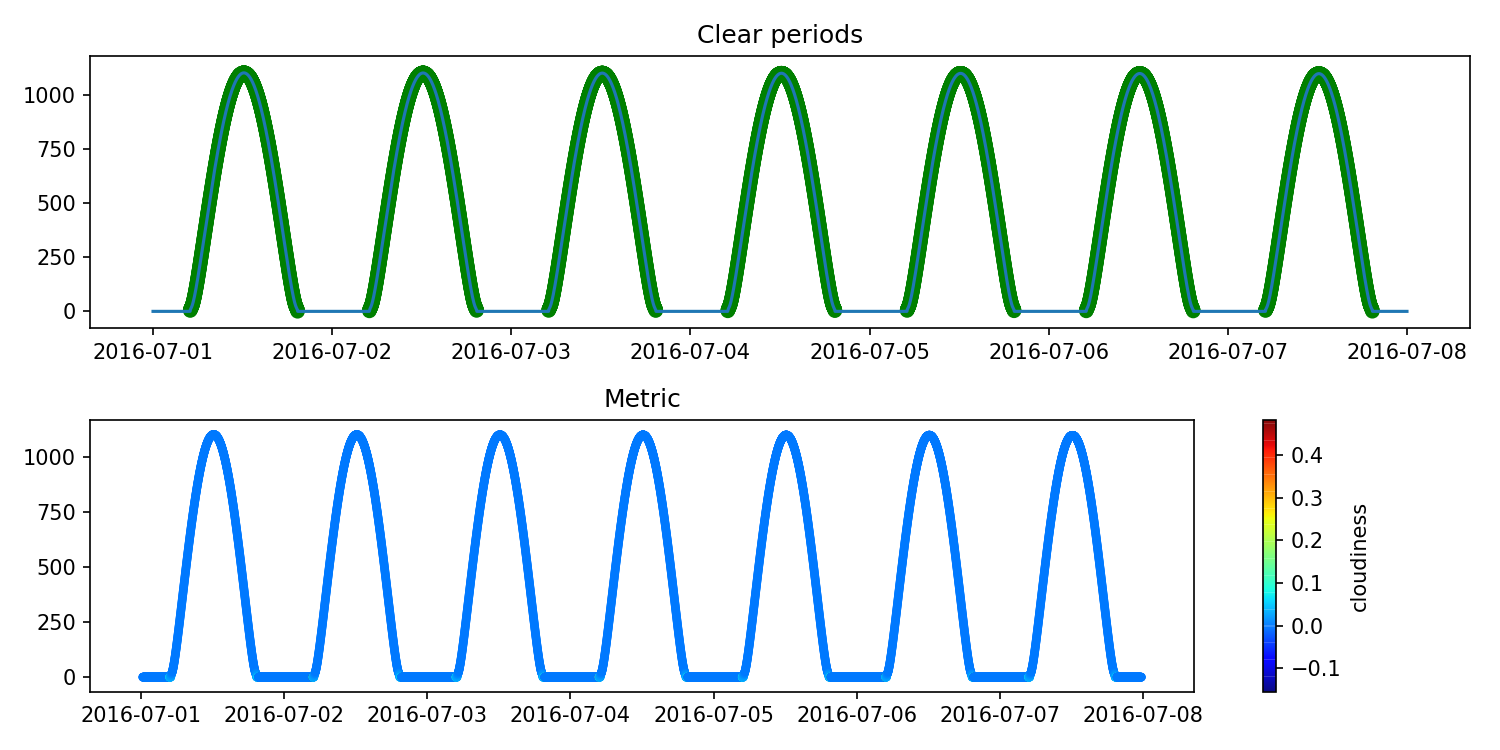

In [17]:
metrics_plot(clear_skies, is_clear, cs_result)

### Democratic method

In [18]:
is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(clear_skies, metric_tol=.05, vote_pct=.75, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:99: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


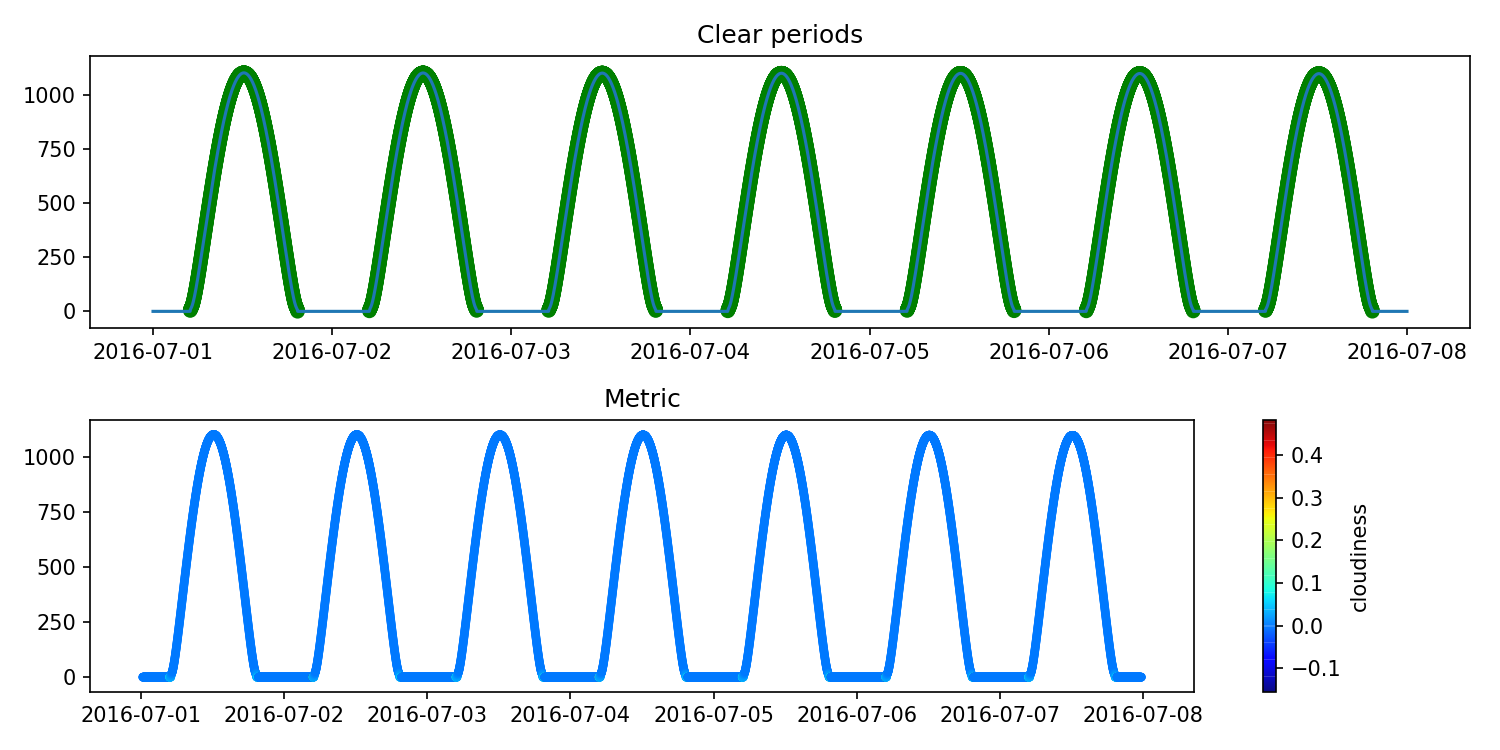

In [19]:
metrics_plot(clear_skies, is_clear, cs_result)

### Mean method

In [20]:
is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(clear_skies, metric_tol=.05, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:153: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


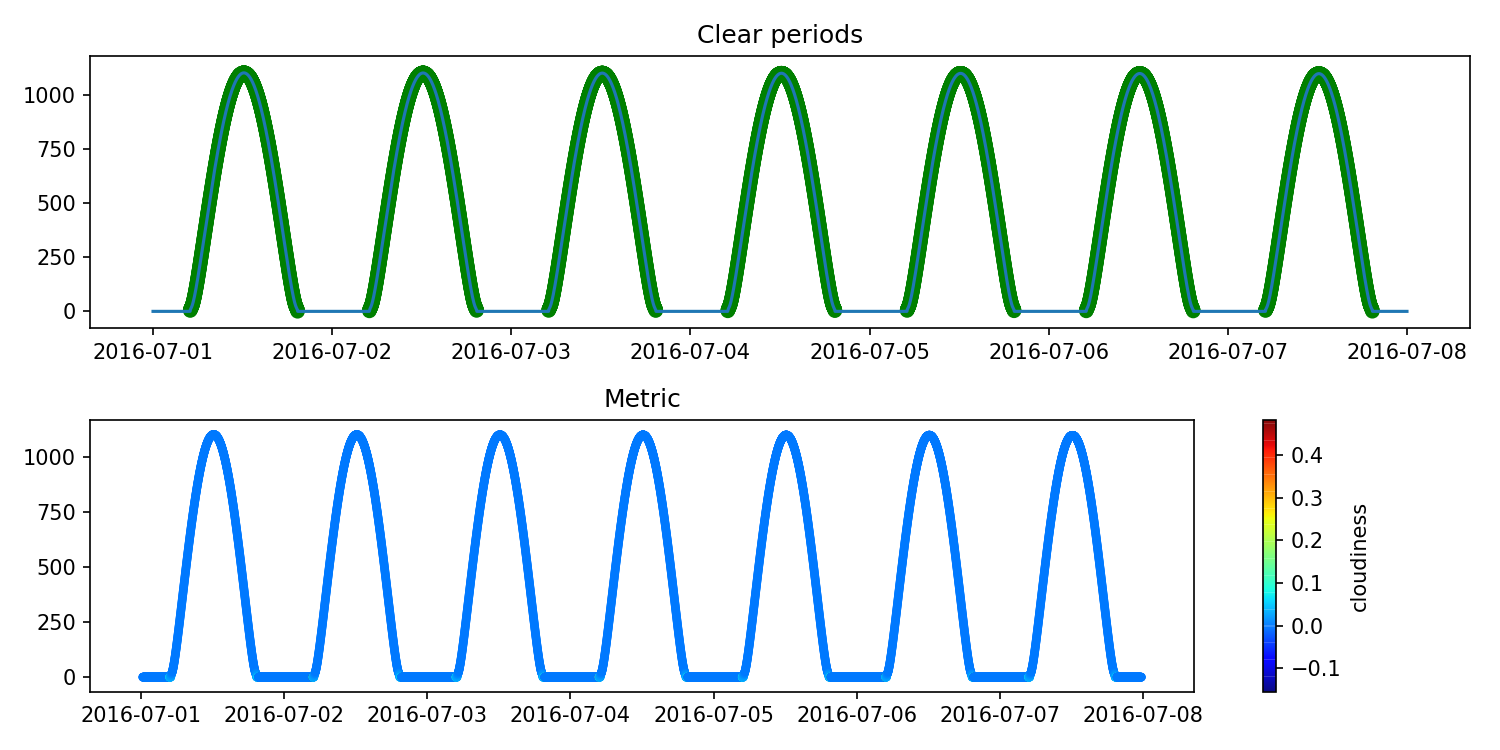

In [21]:
metrics_plot(clear_skies, is_clear, cs_result)

All three variations of the model-free detection algorithms give consistent values for the cloudiness factor over the course of a day which is encouraging.  Using the tolerances we also see that all periods during the day are labeled clear.  We will apply these methods to a week in July to see how the method performs on noisy data.

## Samples from SNL

Get pvlib clear sky times for comparison using standard/default parameters.

In [22]:
pvlib_is_clear = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10)

/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:658: RuntimeWarning: invalid value encountered in true_divide
  meas_slope_nstd = np.std(meas_slope, axis=0, ddof=1) / meas_mean
/Users/benellis/miniconda3/lib/python3.5/site-packages/pvlib/clearsky.py:683: RuntimeWarning: invalid value encountered in less
  c4 = meas_slope_nstd < var_diff


### Standard method

In [23]:
is_clear, result = clearsky_detect_model_free.model_free_detect(sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:55: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


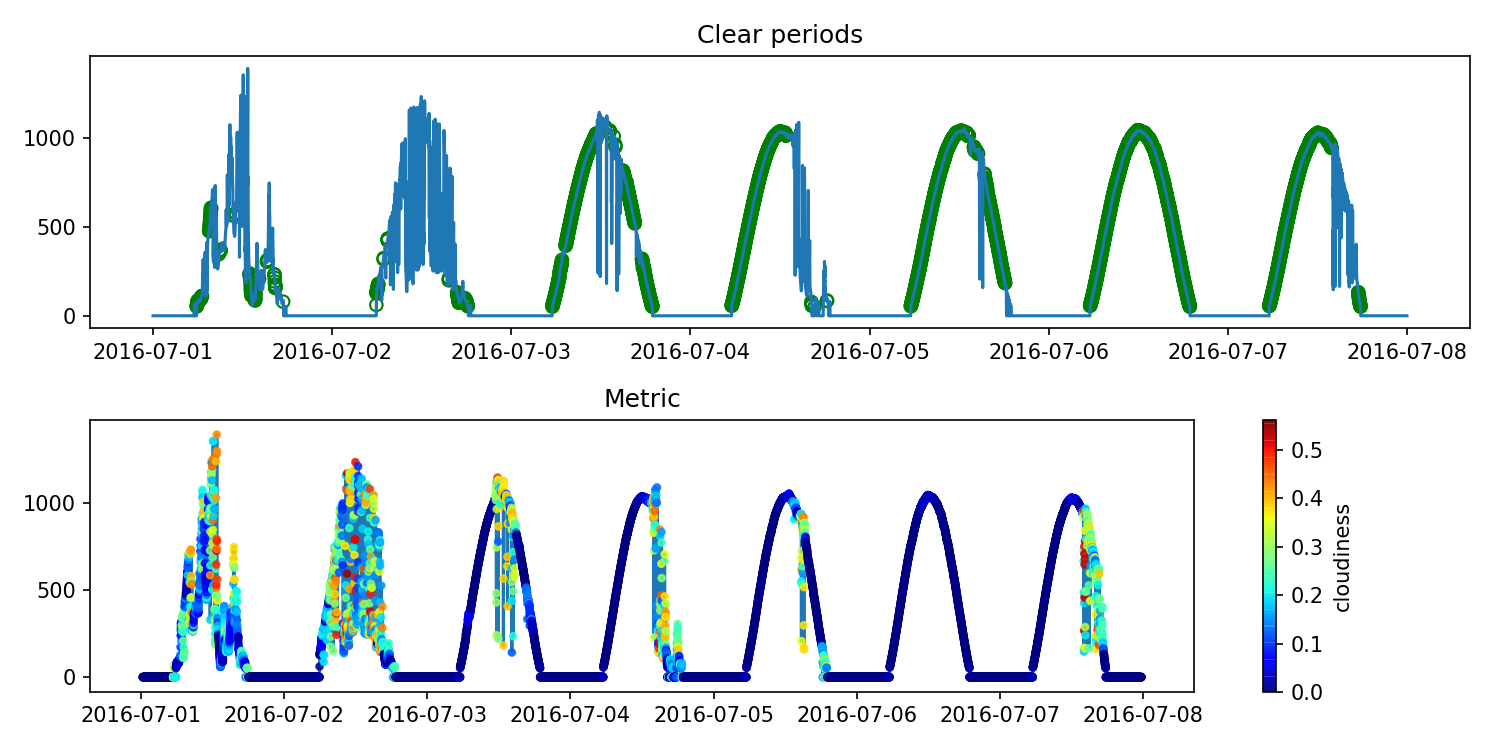

In [24]:
metrics_plot(sample, is_clear, result)

<IPython.core.display.Javascript object>


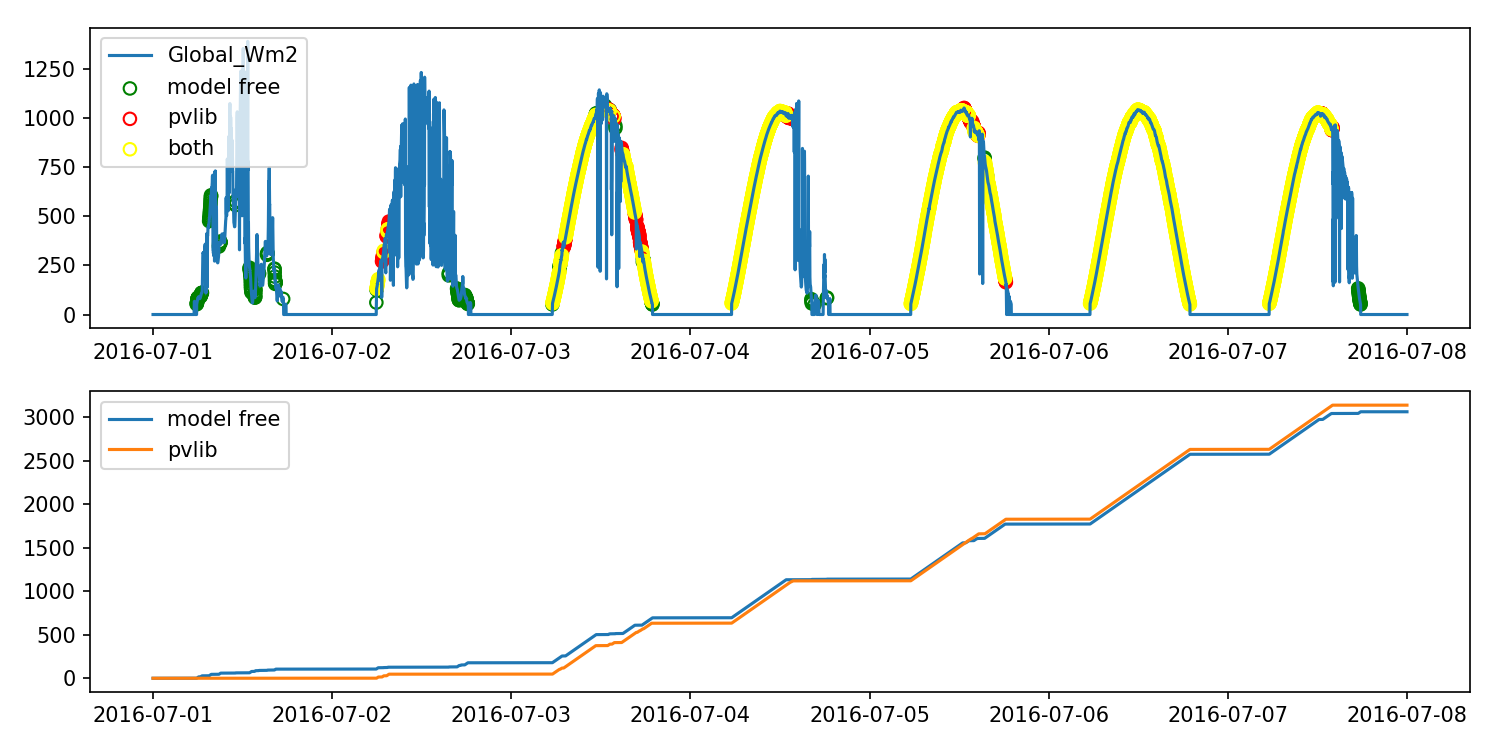

In [25]:
pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear)

The standard model-free based approach is more generous than PVLib methods.  The model-free approach also fails at some fairly obvious locations (July 1st mid-late day, July 4th late day).

### Democratic method

In [26]:
is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:99: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


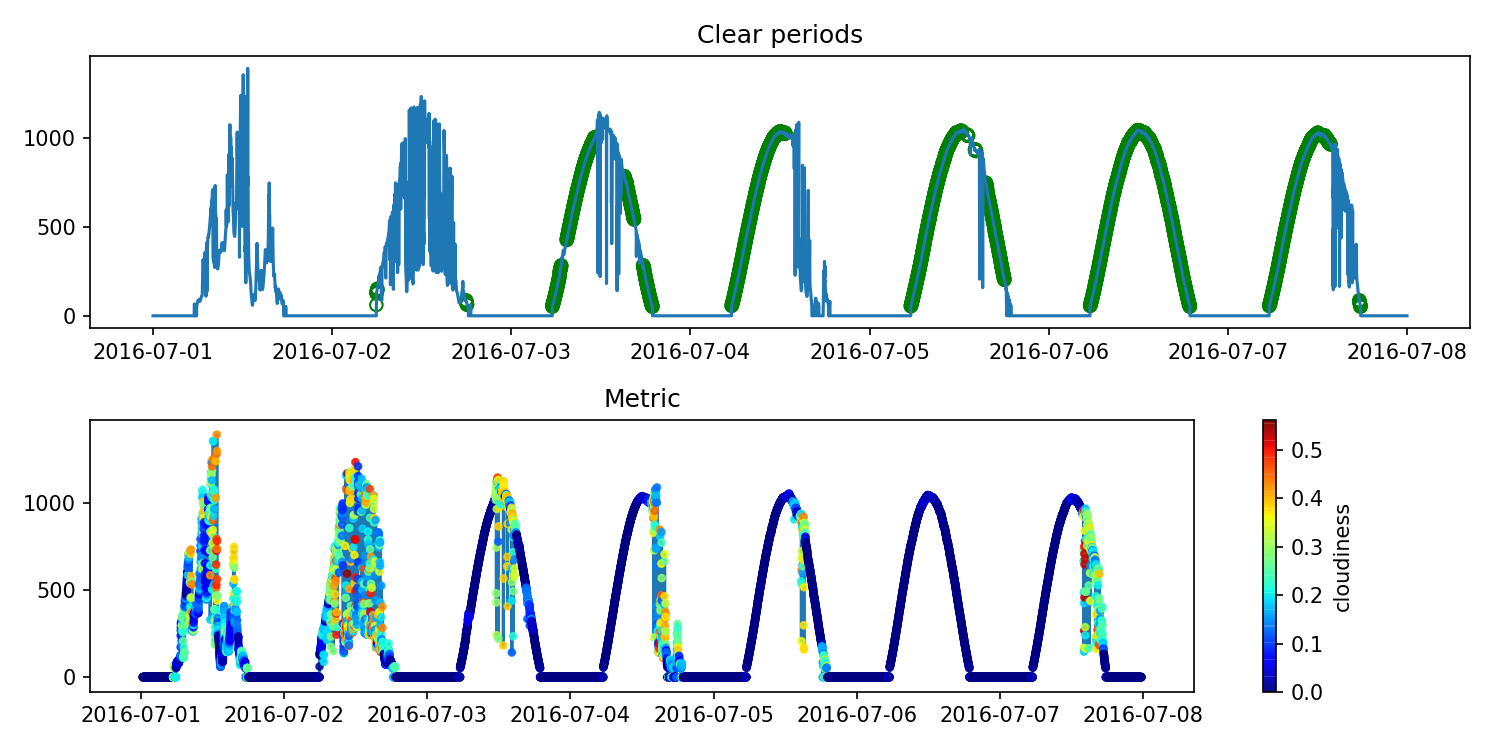

In [27]:
metrics_plot(sample, is_clear, result)

<IPython.core.display.Javascript object>


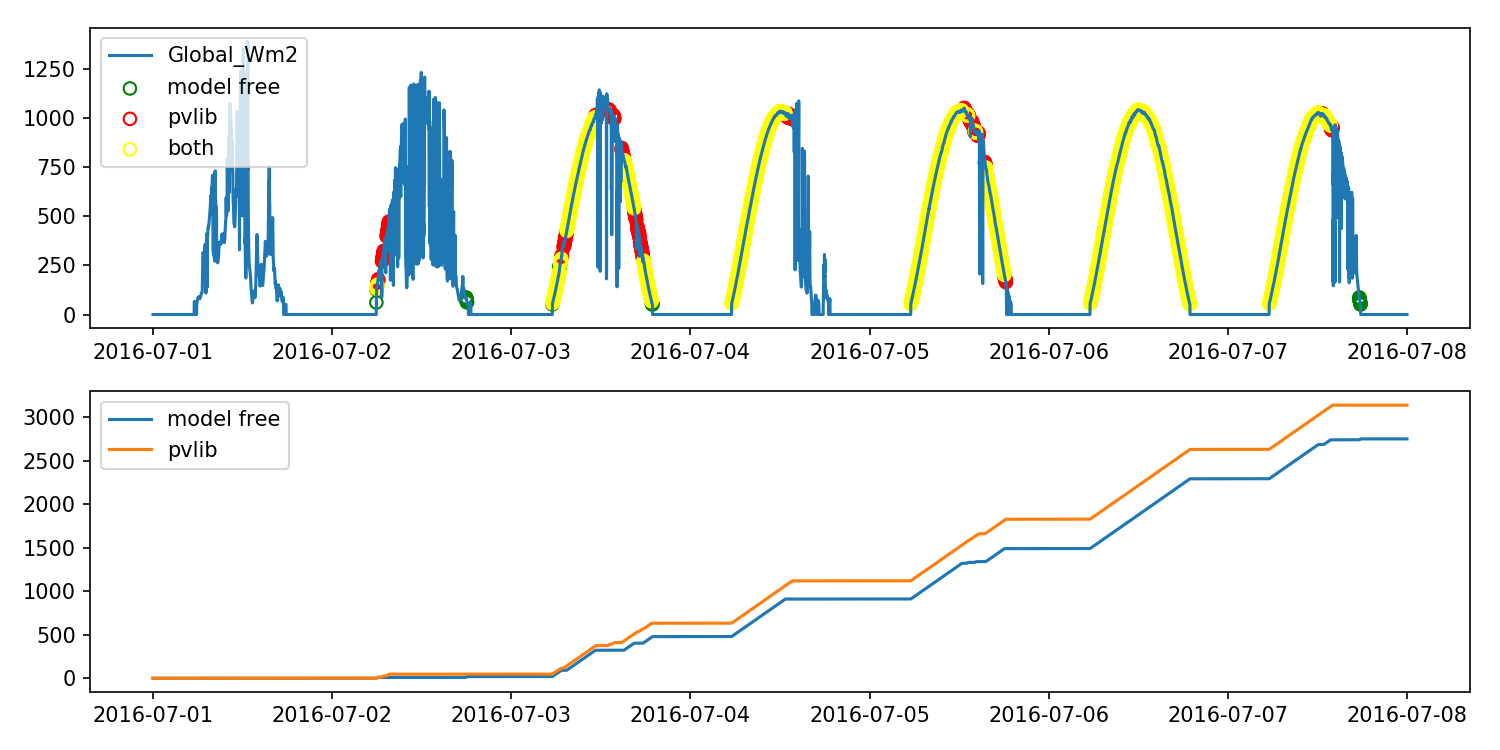

In [28]:
pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear)

The democratic method performs very similarly to PVLib over the course of the week.  The model-free method here is friendlier to early morning and late nights.

### Mean method

In [29]:
is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(sample, verbose=True)

/Users/benellis/rdtools/model_free/clearsky_detect_model_free.py:153: RuntimeWarning: divide by zero encountered in log
  metric = pd.Series(np.log(distances) / np.log(integrals), index=data.index)


<IPython.core.display.Javascript object>


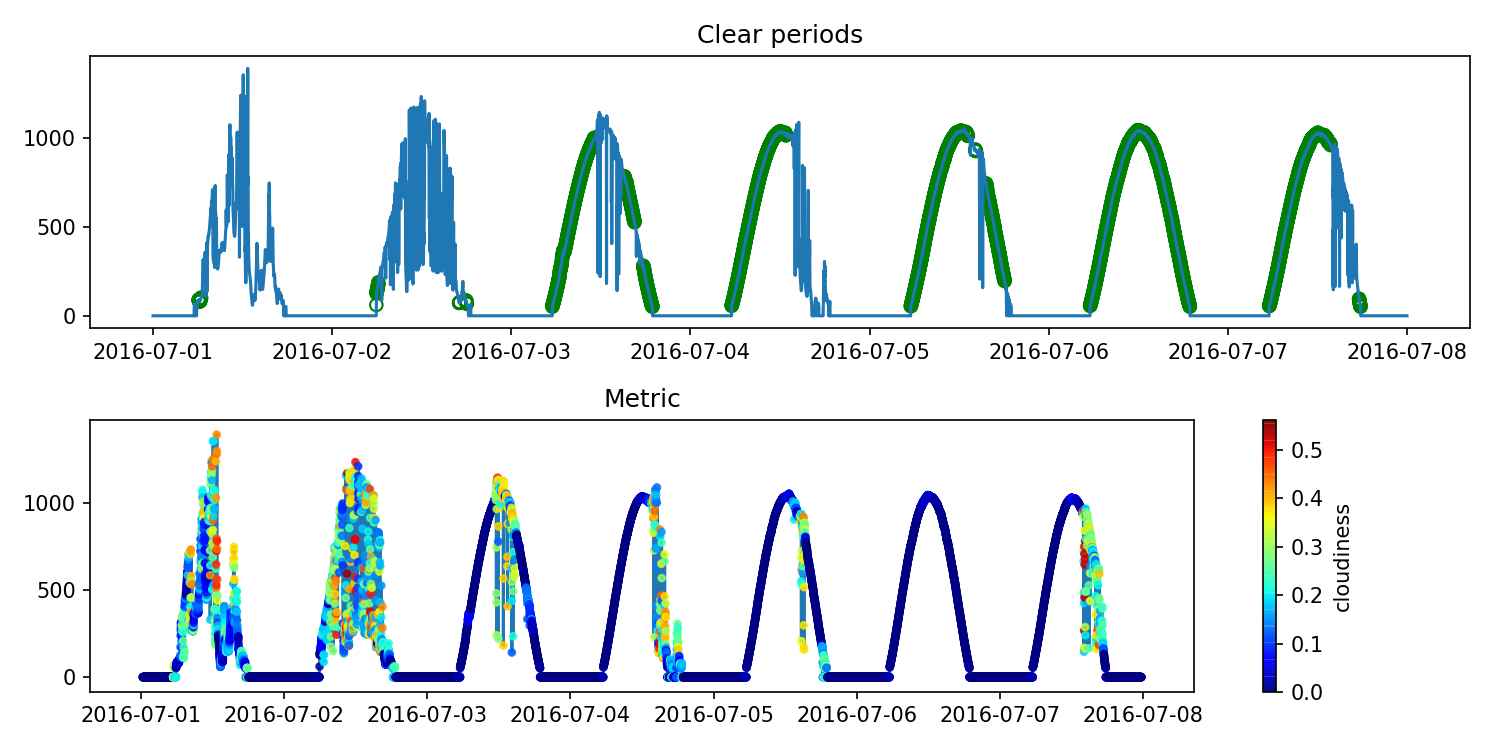

In [30]:
metrics_plot(sample, is_clear, result)

<IPython.core.display.Javascript object>


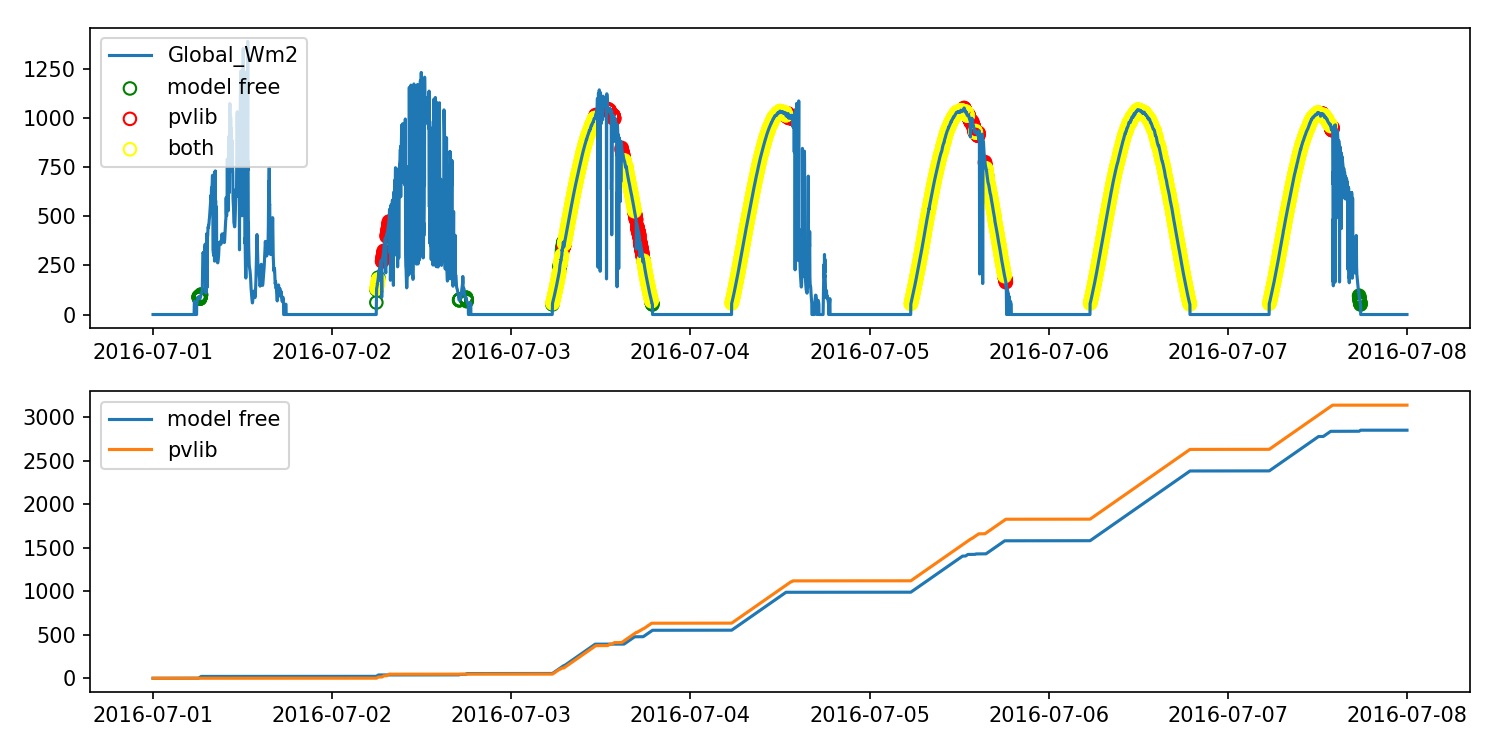

In [31]:
pvlib_compare_plot(sample, clear_skies, is_clear, pvlib_is_clear)

The mean method also performs similarly to the PVLib method.  We see that it is still generous in early mornings and late nights, but in general we see very good agreement.

# Conclusions

A simplified detection model seems to perform similarly to the accepted PVLib method.  The standard model-free method is a bit too generous with periods of obvious cloudiness.  In another notebook we will try using a site that the PVLib method struggled with as well as this model free approach to see how the methods generalize to diverse sites.

It would not surprise me if the model-free method struggles to be generalizable 'out of the box'.  Assuming this is/will be a problem, there is likely a way to normalize the data which might help.